# Template for coursework - Part 2: Clustering

In [1]:
# import of libraries
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score



## Team identification

* seminar day and time
ST 9:15
* team number
Team D
* names of team members
Michal Červinka, Filip Dvořák, Tomáš Jareš, Dominik Šimon

# Introduction

1.	Describe the business value of addressing this problem with machine learning.

    Použití strojového učení na dataset diabetu může výrazně přispět k zlepšení zdravotní péče. Umožňuje časnou detekci a diagnostiku diabetu, vytváření personalizovaných léčebných plánů, předpovídání pravděpodobnosti komplikací, stratifikaci pacientů na základě rizika a efektivní řízení a sledování nemoci. Tímto způsobem může strojové učení zlepšit klinické 
    rozhodování, výsledky pacientů a přispět k efektivnějšímu poskytování zdravotní péče.

2.	Provide the link to the source of the data.
    https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

## Customization

//TODO

1.	What is the *target attribute*
2.	What is the *instance of interest*   The instance can be identified, for example, by an id.
3.	Choose an *attribute of interest* 
5.	Show *Cost matrix* consisting of a cost of a false positive, false negative, true positive and true negative. Note that cost of true positive and true negative is recommended to be zero.

# Data preprocessing

## Preprocessing for unsupervised machine learning 

* As clustering is  performed only on the chosen subset of data, remove data not in the subgroup
* Perform min-max feature rescaling
* remove target attribute from clustering
* do *not* create train-test splits

In [2]:
data = pd.read_csv("diabetes_prediction_dataset.csv")
data

#Vybrání dat bez cílové proměnné
X = data.drop('diabetes', axis=1)

#Vytvoření subsetu
X=X[X['age']>=50]
X=X[X['HbA1c_level']>=6.5]
print(X.head())

#Doplnění chbějících pozorování pro smoking history
value_counts = X[X['smoking_history'] != 'No Info']['smoking_history'].value_counts()
total_count = value_counts.sum()
distribution = (X['smoking_history'].value_counts() / total_count).drop('No Info')
random= np.random.choice(distribution.index,X[X['smoking_history'] == 'No Info'].shape[0] ,p=distribution.values)

X['smoking_history'].loc[X['smoking_history'] == 'No Info'] = random


#Odebrání řádků, kde je atribut gender "Other"
X = X.drop(X[X['gender'] == 'Other'].index)

#Převedení kategoriálních atributů na binární
X = pd.get_dummies(X, columns=['gender'])
print(X['smoking_history'].value_counts())
X = pd.get_dummies(X, columns=['smoking_history'])



#MinMax scaling
scaler = MinMaxScaler()
X[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit_transform(X[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])
print(X.describe()) #tabulka pro kontrolu min a max value 



    gender   age  hypertension  heart_disease smoking_history    bmi  \
0   Female  80.0             0              1           never  25.19   
1   Female  54.0             0              0         No Info  27.32   
15    Male  78.0             0              0         No Info  27.32   
23  Female  72.0             0              1          former  27.94   
26    Male  67.0             0              1     not current  27.32   

    HbA1c_level  blood_glucose_level  
0           6.6                  140  
1           6.6                   80  
15          6.6                  126  
23          6.5                  130  
26          6.5                  200  
smoking_history
never          4687
former         2268
current        1105
not current    1023
ever            681
Name: count, dtype: int64
               age  hypertension  heart_disease          bmi  HbA1c_level  \
count  9764.000000   9764.000000    9764.000000  9764.000000  9764.000000   
mean      0.503448      0.186604     

C:\Users\cervi\AppData\Local\Temp\ipykernel_24952\637956738.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X['smoking_history'].loc[X['smoking_history'] == 'No Info'] = random


## Modeling and visualization

* do not include target attribute among variables for clustering

### Clustering 1 (k-means)

* Use the elbow curve graph to find the best value of inertia (wcss)
* It is recommended to use two measures (such as the Silhouette score and the Inertia) and compare the resulting number of clusters based on their best values.
* Create a scatter plot for each cluster and use color

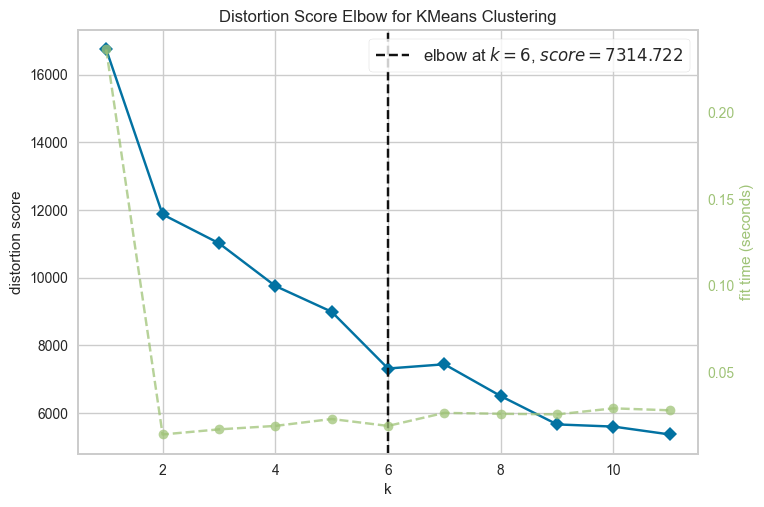

KMeans(n_clusters=4, random_state=42)

In [3]:
#KElbow visualization
kmeans_tune = KMeans(random_state=42,n_init = 2,max_iter=10)
visualizer = KElbowVisualizer(kmeans_tune, k=(1,12),metric="distortion")
visualizer.fit(X)
visualizer.show()
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

In [4]:
# spočítání Silhouette Score:
silhouette_avg = silhouette_score(X, kmeans.labels_)
print("average silhouette_score:", silhouette_avg)

#výpis inertii
print("inertia: ", kmeans.inertia_)

average silhouette_score: 0.2394578329466852
inertia:  9806.514085674524


[[-1.99529342e-03  5.53170708e-03  7.11607431e-02 -1.70611271e-03
   2.30050225e-02  1.47544755e-02 -6.75284384e-01  6.75284384e-01
   3.28296843e-02  2.55686996e-02  1.61592298e-01 -2.32657814e-01
   1.26671321e-02]
 [ 1.20615165e-02 -7.88747628e-04  1.85697095e-02  1.80811327e-03
   6.97588454e-04  5.81680657e-03  2.03349409e-01 -2.03349409e-01
   1.17819411e-01  5.71761923e-02  5.04553066e-01 -7.94830367e-01
   1.15281697e-01]]


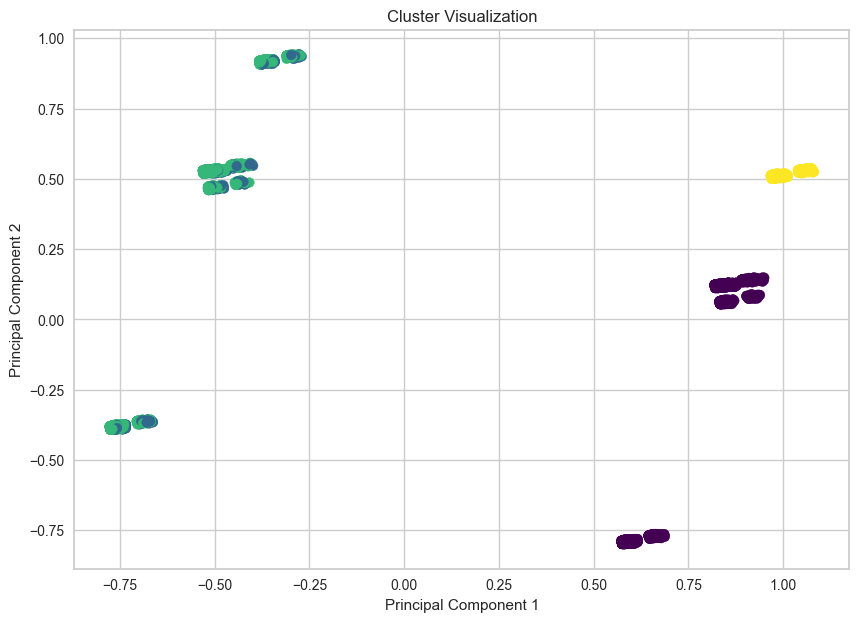

In [5]:
# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
print(pca.components_)

# Create a DataFrame with the two principal components
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Add the cluster labels to this DataFrame
principalDf['Cluster'] = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=principalDf['Cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization')
plt.show()


### Clustering  2 (hierarchical)

* Try to use the dendrogram to identify outliers. If an instance joins a cluster higher on the dendrogram, it generally means it is less similar to the other instances. 

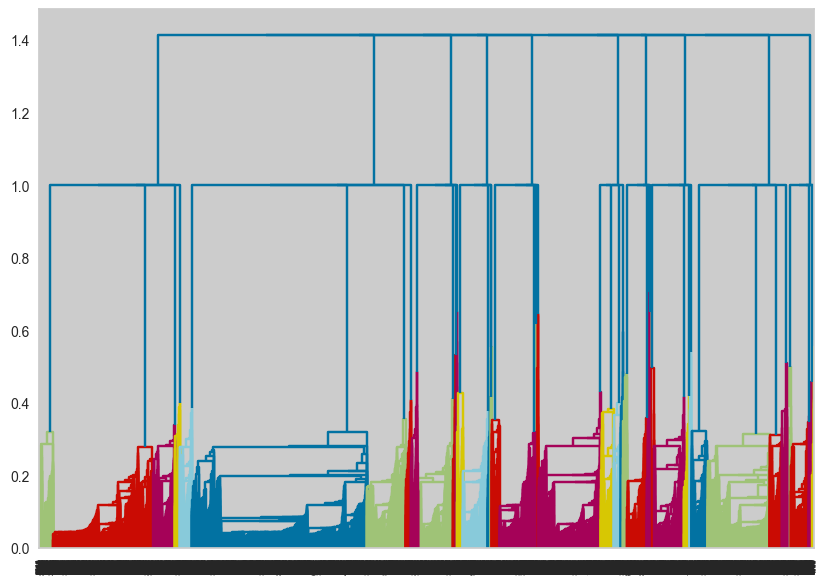

In [6]:
# Perform hierarchical clustering
linked = linkage(X, 'single')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

# Evaluation

## Global

### Clustering 1 (k-means)

* Compute the rand index using the value of the target attribute

In [7]:
# Assuming 'data' is your original DataFrame and 'X' is your preprocessed data
y = data.loc[X.index, 'diabetes']

# Compute Adjusted Rand Index
ari = adjusted_rand_score(y, kmeans.labels_)

print("ARI: ", ari)


ARI:  0.026354054977239395


### Clustering 2 (hierarchical)


* Compute the rand index using the value of the target attribute

In [8]:
# Assuming 'Z' is the linkage matrix obtained from hierarchical clustering
# and 'k' is the number of clusters you decided based on the dendrogram
clusters = fcluster(linkage, 1.4, criterion='maxclust')

# Assuming 'data' is your original DataFrame and 'X' is your preprocessed data
y = data.loc[X.index, 'diabetes']

# Compute Adjusted Rand Index
ari = adjusted_rand_score(y, clusters)

print("ARI: ", ari)


TypeError: float() argument must be a string or a real number, not 'function'

## Local

*	Use the model to classify the chosen instance into a cluster

# Explanation

## Global explanation

### Clustering 1 - k-means

*	Interpret the final clusters based on their centroids and the number of instances in each cluster.

### Clustering 2 - hierarchical

* Plot the dendrogram for clustering

## Local explanation

* Use both models to show what cluster is assigned to the *instance of interest*
* Comment on the assigned cluster.

# Conclusion
Summarize the results, answering questions such as:

1.	Which clustering provided the most useful result? 
2.	What setting provided the best result?

# Optional parts

## Local explanation

*	Does the value of the target class in the data match with the mode (average) of the assigned cluster? As the target attribute was not included in the clustering, to compute this, you need to  match the instance of interest as well as the instances in the assigned cluster with the original input data and use this to obtain the target value (and compute the mean/mode for the assigned cluster)